In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import json
from unidecode import unidecode
from nltk.tokenize import word_tokenize
import community 
import os
from collections import Counter

In [3]:
def clean_name(name):
    name = name.replace('"', '')
    return unidecode(name)

In [4]:
# Read the data from the csv file
senate_df = pd.read_csv('usa_data/senators.csv')
house_df = pd.read_csv('usa_data/house.csv')

# clean all names
senate_df['Senator'] = senate_df['Senator'].apply(clean_name)
house_df['Member'] = house_df['Member'].apply(clean_name)

senators = senate_df['Senator'].tolist()
representatives = house_df['Member'].tolist()

senators_names = [clean_name(name) for name in senators]
representatives = [clean_name(name) for name in representatives]

# remove representatives that are vacant
representatives = [x for x in representatives if x != 'Vacant']

In [5]:
# load the JSON string back into a dictionary
with open('usa_data/house_links.json', 'r') as f:
    house_links = json.loads(f.read())

with open('usa_data/senate_links.json', 'r') as f:
    senate_links = json.loads(f.read())

In [6]:
# create a graph object
congress_dict = {**house_links, **senate_links}

congress_graph = nx.DiGraph()

# add nodes to the graph
congress_graph.add_nodes_from(senators)
congress_graph.add_nodes_from(representatives)

for key, values in congress_dict.items():
    for value in values:
        congress_graph.add_edge(key, value)

party = senate_df['Party'].unique().tolist()

# add house, senate and state attributes to the nodes
for node in congress_graph.nodes():
    if node in senators:
        congress_graph.nodes[node]['chamber'] = 'Senate'
        try: 
            congress_graph.nodes[node]['party'] = senate_df.loc[senate_df['Senator'] == node]['Party'].values[0]
            congress_graph.nodes[node]['state'] = senate_df.loc[senate_df['Senator'] == node]['State'].values[0]
        except:
            print(node)
            print(senate_df.loc[senate_df['Senator'] == node]['Party'].values)
        

    elif node in representatives:
        try: 
            congress_graph.nodes[node]['chamber'] = 'House'
            congress_graph.nodes[node]['party'] = house_df.loc[house_df['Member'] == node]['Party'].values[0]
            congress_graph.nodes[node]['state'] = house_df.loc[house_df['Member'] == node]['District'].values[0]
        except:
            print(node)
            print(house_df.loc[house_df['Member'] == node]['Party'].values)



print(congress_graph)
# to do, remove number on district

DiGraph with 533 nodes and 3026 edges


In [7]:
# find most connected node based on House

# find most connected rappers from east and west coast
in_degrees = sorted(congress_graph.in_degree, key=lambda x: x[1], reverse=True)
out_degrees = sorted(congress_graph.out_degree, key=lambda x: x[1], reverse=True)

in_house = []
in_senate = []
out_house = []
out_senate = []

for node in in_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        in_house.append(node)
    else:
        in_senate.append(node)

for node in out_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        out_house.append(node)
    else:
        out_senate.append(node)


In [8]:
# Most connected east coast rappers
print("Top 5 highest out-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_house[i])[1:-1])

print("\n")
print("Top 5 highest out-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_senate[i])[1:-1])

Top 5 highest out-degree members of house of representatives:
1)'Marjorie Taylor Greene', 34
2)'Chip Roy', 31
3)'Alexandria Ocasio-Cortez', 27
4)'Kevin McCarthy', 26
5)'Josh Gottheimer', 21


Top 5 highest out-degree members of senate:
1)'Joe Manchin', 31
2)'Chuck Schumer', 24
3)'Tom Cotton', 22
4)'Ron Wyden', 22
5)'Bernie Sanders', 22


In [9]:
# Most connected east coast rappers
print("Top 5 highest in-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_house[i])[1:-1])

print("\n")
print("Top 5 highest in-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_senate[i])[1:-1])

Top 5 highest in-degree members of house of representatives:
1)'Nancy Pelosi', 100
2)'Kevin McCarthy', 71
3)'Alexandria Ocasio-Cortez', 35
4)'Marjorie Taylor Greene', 32
5)'Jim Jordan', 25


Top 5 highest in-degree members of senate:
1)'Bernie Sanders', 62
2)'Ted Cruz', 43
3)'Mitch McConnell', 40
4)'Chuck Schumer', 40
5)'Elizabeth Warren', 38


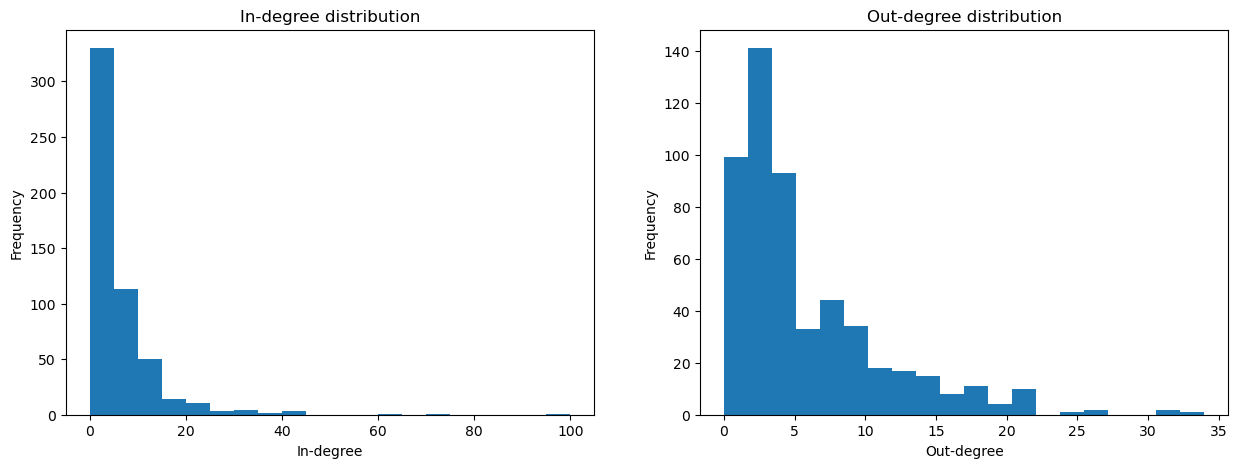

In [10]:
# Make histogram of in and out degree graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist([x[1] for x in in_degrees], bins=20)
plt.title('In-degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist([x[1] for x in out_degrees], bins=20)
plt.title('Out-degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.show()

In [11]:
# draw the graph

color = []

for node in congress_graph.nodes():
    if congress_graph.nodes[node]['party'] == 'Republican':
        color.append('red')
    elif congress_graph.nodes[node]['party'] == 'Democratic':
        color.append('blue')
    else:
        color.append('green')

size = [degree*10 for node, degree in congress_graph.degree()]

# remove isolated nodes
#congress_graph.remove_nodes_from(list(nx.isolates(congress_graph)))

# remove self loops
#congress_graph.remove_edges_from(nx.selfloop_edges(congress_graph))

In [12]:
pos = nx.kamada_kawai_layout(congress_graph)

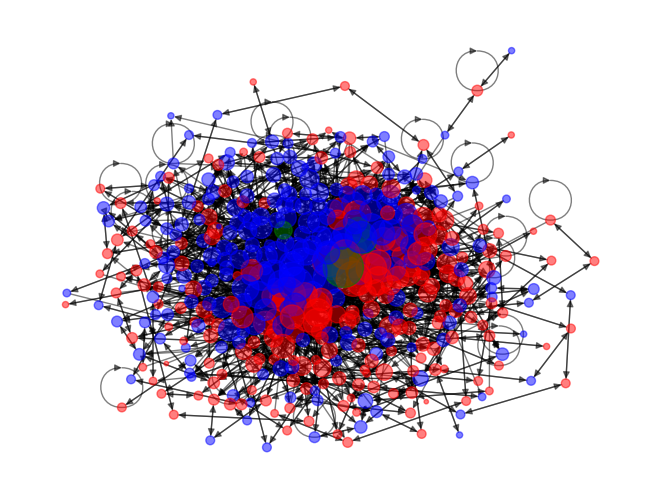

In [13]:
nx.draw(congress_graph, pos, font_size=8, node_color=color, node_size=size, alpha=0.5)

In [14]:
# create table with all the nodes stats
stats_df = pd.DataFrame()

for node in congress_graph.nodes():
    new_row = pd.DataFrame([[node, 
                            congress_graph.in_degree(node),
                            congress_graph.out_degree(node), 
                            nx.degree_centrality(congress_graph)[node]
                            ]])
    stats_df = pd.concat([stats_df,new_row], axis = 0, ignore_index=True)


# set the column names
stats_df.columns = ['Name', 'In-degree', 'Out-degree', 'Degree centrality']
print(stats_df)

                 Name  In-degree  Out-degree  Degree centrality
0    Tommy Tuberville          6           5           0.020677
1         Katie Britt          5           9           0.026316
2      Lisa Murkowski         14          12           0.048872
3        Dan Sullivan          0           0           0.000000
4      Kyrsten Sinema         14          18           0.060150
..                ...        ...         ...                ...
528  Scott Fitzgerald          0           0           0.000000
529    Glenn Grothman          1           1           0.003759
530       Tom Tiffany          2           1           0.005639
531    Mike Gallagher          0           0           0.000000
532   Harriet Hageman          2           4           0.011278

[533 rows x 4 columns]


In [15]:
# print nodes with highest degree centrality
print("Top 5 highest degree centrality:")
print(stats_df.sort_values(by=['Degree centrality'], ascending=False).head(10))

Top 5 highest degree centrality:
                         Name  In-degree  Out-degree  Degree centrality
131              Nancy Pelosi        100          18           0.221805
140            Kevin McCarthy         71          26           0.182331
88             Bernie Sanders         62          22           0.157895
228    Marjorie Taylor Greene         32          34           0.124060
62              Chuck Schumer         40          24           0.120301
85                   Ted Cruz         43          21           0.120301
370  Alexandria Ocasio-Cortez         35          27           0.116541
40           Elizabeth Warren         38          17           0.103383
94                Joe Manchin         21          31           0.097744
16                Marco Rubio         34          16           0.093985


Communities

In [16]:
congress_graph_undirected = congress_graph.to_undirected()

In [ ]:
# Detect communities using the Python-Louvain algorithm
partition = community.best_partition(congress_graph_undirected, random_state = 1) # random state is a seed for reproducibility

Check how many communities 

In [ ]:
### Get number of communities in partition
num_communities = max(partition.values()) + 1
print(f'We have partitioned the network into {num_communities} communities. ')

We have partitioned the network into 92 communities. 


In [ ]:
### Get modularity of partition
print(f'The modularity of the partition is M = {community.modularity(partition, congress_graph_undirected)}')

The modularity of the partition is M = 0.41948414640997034


Now, let us visualize the sizes of the detected communities. First, we get a list of all communities. 

In [ ]:
### Get a list of all communities in list form
communities = [list() for _ in range(num_communities)]

for node, community_id in partition.items():
    communities[community_id].append(node)

### Sort communities from largest to smalles
communities = sorted(communities, key=len, reverse=True)

We now easily get the sizes of each community as

In [ ]:
community_sizes = [len(com) for com in communities]

Now, we can make a barchart to compare the sizes of the communities. 

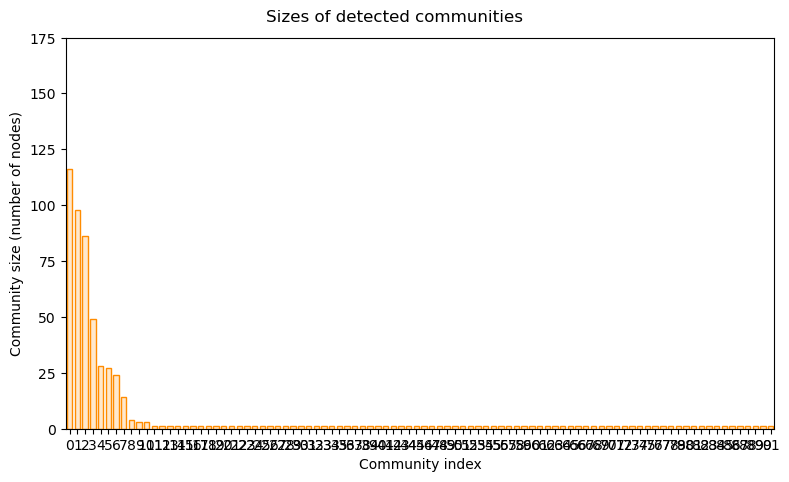

In [ ]:
orange1 = (255/255, 140/255, 0/255, 0.2)
orange2 = (255/255, 140/255, 0/255, 1)

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle(r"Sizes of detected communities", size=12, y=0.955)

ax.set_ylabel('Community size (number of nodes)', size=10)
ax.set_xlabel('Community index', size=10) 

ax.bar([i for i in range(len(community_sizes))], community_sizes, width=0.7, fc=orange1, ec=orange2, lw=1)

ax.set_xticks([i for i in range(len(community_sizes))])
ax.set_xticklabels([i for i in range(len(community_sizes))], size=10)
ax.set_xlim(0-0.5, len(community_sizes)-0.5)

ax.set_yticks([25*i for i in range(8)])
ax.set_yticklabels([25*i for i in range(8)], size=10)

plt.tight_layout()

Plot the communties

Community sizes: [116, 1, 24, 1, 49, 86, 1, 98, 1, 1, 1, 28, 1, 1, 27, 1, 1, 1, 1, 1, 1, 1, 1, 1, 14, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


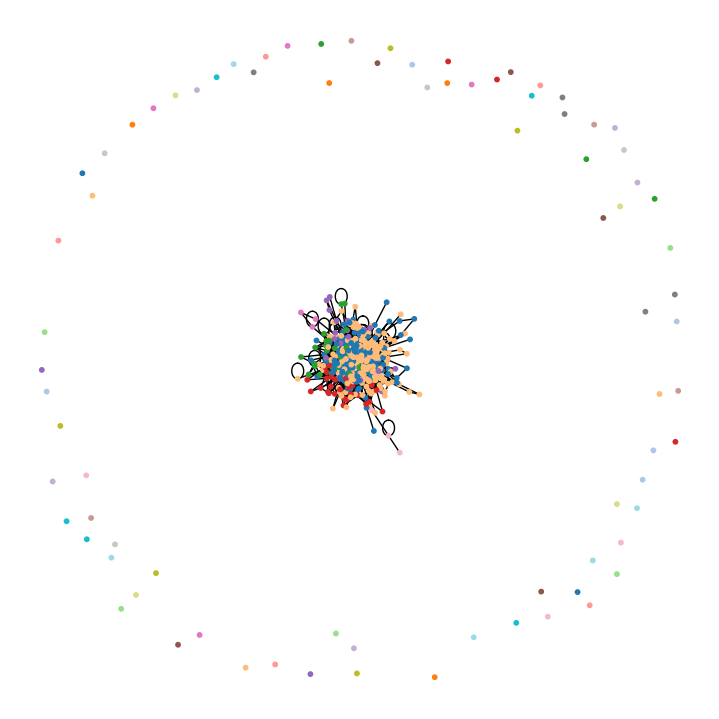

In [73]:
# Get the community ID for each node
community_ids = list(partition.values())

# print community sizes
community_sizes = list(Counter(community_ids).values())
print("Community sizes:", community_sizes)

# Define a colormap for visualizing communities
colormap = plt.cm.get_cmap("tab20", max(community_ids) + 1)

# Map community IDs to colors
node_colors = [colormap(community_id) for community_id in community_ids]

# Draw the network graph with community-based node colors
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(congress_graph_undirected, seed=42)
nx.draw(congress_graph_undirected, pos, node_color=node_colors, with_labels=False, node_size=10)
plt.show()

In [74]:
republican_count = 0
democratic_count = 0
community_idx = 0
republican_democratic_community_count = []

for com in communities:
    for node in com:
        ### Append count if rapper is from West Coast
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            
        ### Append count if rapper is from East Coast
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
    
    ### Append community index, count of West Coast-rappers and count of East Coast-rappers to community_count
    republican_democratic_community_count.append((community_idx, republican_count, democratic_count))
    
    ### Reset counts and update index
    republican_count = 0
    democratic_count = 0
    community_idx += 1

for v in republican_democratic_community_count:
    print(f'Community {v[0]} has {v[1]} Republicans and {v[2]} Democrats')

Community 0 has 58 Republicans and 54 Democrats
Community 1 has 75 Republicans and 23 Democrats
Community 2 has 25 Republicans and 61 Democrats
Community 3 has 11 Republicans and 37 Democrats
Community 4 has 14 Republicans and 14 Democrats
Community 5 has 11 Republicans and 16 Democrats
Community 6 has 10 Republicans and 14 Democrats
Community 7 has 6 Republicans and 8 Democrats
Community 8 has 1 Republicans and 3 Democrats
Community 9 has 2 Republicans and 1 Democrats
Community 10 has 1 Republicans and 2 Democrats
Community 11 has 1 Republicans and 0 Democrats
Community 12 has 1 Republicans and 0 Democrats
Community 13 has 0 Republicans and 1 Democrats
Community 14 has 1 Republicans and 0 Democrats
Community 15 has 0 Republicans and 1 Democrats
Community 16 has 1 Republicans and 0 Democrats
Community 17 has 1 Republicans and 0 Democrats
Community 18 has 1 Republicans and 0 Democrats
Community 19 has 1 Republicans and 0 Democrats
Community 20 has 1 Republicans and 0 Democrats
Community

In [75]:
senators_count = 0
representatives_count = 0
community_idx = 0
senators_representatices_community_count = []

for com in communities:
    for node in com:
        ### Append count if rapper is from West Coast
        if node in senators_names:
            senators_count += 1
            
        ### Append count if rapper is from East Coast
        elif node in representatives:
            representatives_count += 1
    
    ### Append community index, count of West Coast-rappers and count of East Coast-rappers to community_count
    senators_representatices_community_count.append((community_idx, senators_count, representatives_count))
    
    ### Reset counts and update index
    senators_count = 0
    representatives_count = 0
    community_idx += 1

for v in senators_representatices_community_count:
    print(f'Community {v[0]} has {v[1]} senators and {v[2]} representatives')

Community 0 has 89 senators and 27 representatives
Community 1 has 0 senators and 98 representatives
Community 2 has 2 senators and 84 representatives
Community 3 has 2 senators and 47 representatives
Community 4 has 0 senators and 28 representatives
Community 5 has 0 senators and 27 representatives
Community 6 has 4 senators and 20 representatives
Community 7 has 0 senators and 14 representatives
Community 8 has 0 senators and 4 representatives
Community 9 has 0 senators and 3 representatives
Community 10 has 0 senators and 3 representatives
Community 11 has 1 senators and 0 representatives
Community 12 has 1 senators and 0 representatives
Community 13 has 0 senators and 1 representatives
Community 14 has 0 senators and 1 representatives
Community 15 has 1 senators and 0 representatives
Community 16 has 0 senators and 1 representatives
Community 17 has 0 senators and 1 representatives
Community 18 has 0 senators and 1 representatives
Community 19 has 0 senators and 1 representatives
C

In [76]:
sorted_partition = sorted(partition, key=len, reverse=True)
#print(sorted_partition)

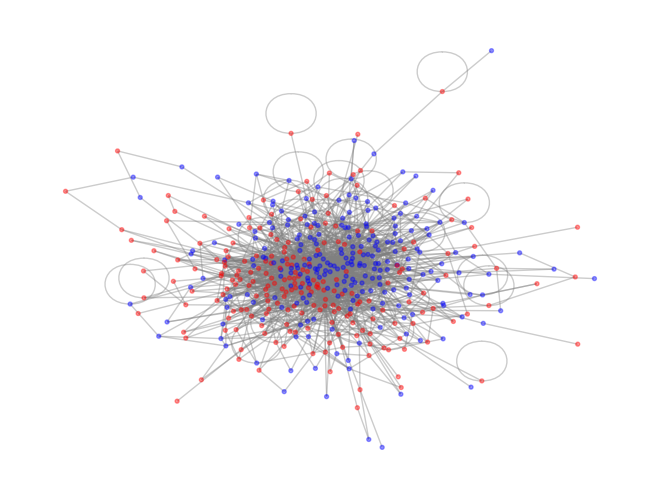

In [77]:

congress_graph_undirected_new = congress_graph_undirected.copy()
# remove isolated nodes
congress_graph_undirected_new.remove_nodes_from(list(nx.isolates(congress_graph_undirected_new)))

# Create a list of colors for node visualization based on the 'coast' attribute
node_colors = ["red" if congress_graph_undirected_new.nodes[node]["party"] == "Republican" else "blue" if congress_graph_undirected_new.nodes[node]["party"] == "Democratic" else "grey" for node in congress_graph_undirected_new.nodes()]


nx.draw(congress_graph_undirected_new, node_color = node_colors, with_labels=False, node_size=8, edge_color='gray', alpha=0.4)

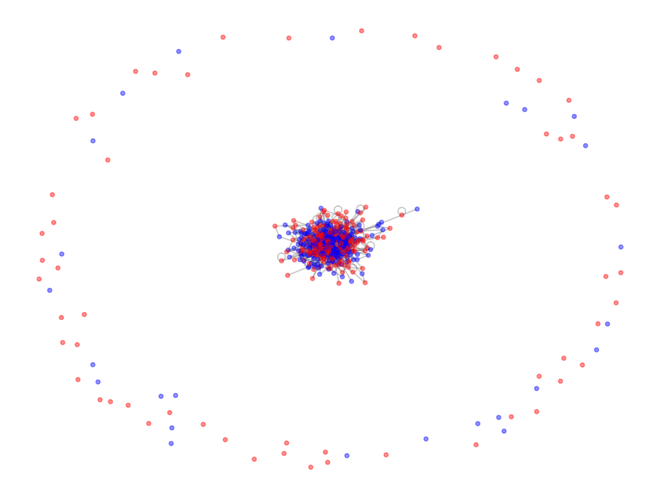

In [78]:
node_colors = ["red" if congress_graph_undirected.nodes[node]["party"] == "Republican" else "blue" if congress_graph_undirected.nodes[node]["party"] == "Democratic" else "grey" for node in congress_graph_undirected.nodes()]


nx.draw(congress_graph_undirected, node_color = node_colors, with_labels=False, node_size=8, edge_color='gray', alpha=0.4)

How many outliers are republicans or democrats?

In [79]:
republican_count_total = 0
democratic_count_total = 0

for v in republican_democratic_community_count[11:]:
    republican_count_total += v[1]
    democratic_count_total += v[2]

print(f'Total Republicans: {republican_count_total}')
print(f'Total Democrats: {democratic_count_total}')


Total Republicans: 56
Total Democrats: 25


In [80]:
# defining a set of the first 10 communities


# defining a set of communties after the first 10
print(senate_df)

            State               Senator           Party  Age  \
0         Alabama      Tommy Tuberville      Republican   69   
1         Alabama           Katie Britt      Republican   41   
2          Alaska        Lisa Murkowski      Republican   66   
3          Alaska          Dan Sullivan      Republican   58   
4         Arizona        Kyrsten Sinema  Independent[d]   47   
..            ...                   ...             ...  ...   
95  West Virginia  Shelley Moore Capito      Republican   69   
96      Wisconsin           Ron Johnson      Republican   68   
97      Wisconsin         Tammy Baldwin      Democratic   61   
98        Wyoming         John Barrasso      Republican   71   
99        Wyoming        Cynthia Lummis      Republican   69   

                                        Occupation(s)  \
0   College football coach Investment management f...   
1   Senate staffer University administrator Lawyer...   
2                                              Lawyer   
3  

In [81]:
total_republican_count = 0
total_democratic_count = 0
total_age_republican = 0
total_age_democratic = 0

for com in communities[11:]:  # Iterate over the last 80 communities
    republican_count = 0
    democratic_count = 0
    
    for node in com:
        # Check the party and accumulate counts and ages
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            try:
                total_age_republican += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_republican += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
            try:
                total_age_democratic += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_democratic += senate_df[senate_df['Senator'] == node]['Age'].values[0]

    # Accumulate counts for each community
    total_republican_count += republican_count
    total_democratic_count += democratic_count

# Calculate overall average age for Republicans and Democrats
avg_age_republican = total_age_republican / total_republican_count if total_republican_count > 0 else 0
avg_age_democratic = total_age_democratic / total_democratic_count if total_democratic_count > 0 else 0

# Print the results
print(f'Overall Average Age of Republicans: {avg_age_republican:.2f}')
print(f'Overall Average Age of Democrats: {avg_age_democratic:.2f}')



Overall Average Age of Republicans: 58.39
Overall Average Age of Democrats: 60.28


In [88]:
# general age average

# print the average age of republican politicians
print("Average age of republicans")
print(senate_df[senate_df['Party'] == 'Republican']['Age'].mean())
print(house_df[house_df['Party'] == 'Republican']['Age'].mean())

# print the average age of democratic politicians
print("Average age of democrats")
print(senate_df[senate_df['Party'] == 'Democratic']['Age'].mean())
print(house_df[house_df['Party'] == 'Democratic']['Age'].mean())

Average age of republicans
63.08163265306123
56.828054298642535
Average age of democrats
64.47826086956522
58.448113207547166


In [82]:
total_republican_count = 0
total_democratic_count = 0
total_age_republican = 0
total_age_democratic = 0

for com in communities[:10]:  # Iterate over the last 80 communities
    republican_count = 0
    democratic_count = 0
    
    for node in com:
        # Check the party and accumulate counts and ages
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            try:
                total_age_republican += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_republican += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
            try:
                total_age_democratic += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_democratic += senate_df[senate_df['Senator'] == node]['Age'].values[0]

    # Accumulate counts for each community
    total_republican_count += republican_count
    total_democratic_count += democratic_count

# Calculate overall average age for Republicans and Democrats
avg_age_republican = total_age_republican / total_republican_count if total_republican_count > 0 else 0
avg_age_democratic = total_age_democratic / total_democratic_count if total_democratic_count > 0 else 0

# Print the results
print(f'Overall Average Age of Republicans: {avg_age_republican:.2f}')
print(f'Overall Average Age of Democrats: {avg_age_democratic:.2f}')


Overall Average Age of Republicans: 57.87
Overall Average Age of Democrats: 59.56


Calculate modularity bewteen republicans and democrats.

In [83]:
# Divide the nodes into two communities based on the coast attribute
# Create a set of nodes from the east coast and west coast based on the CSV files for east coast rappers and west coast rappers
df_rappers = pd.read_csv("data/Rappers.csv")

# Getting the data
east_codes_nodes = df_rappers[df_rappers["Coast"]=="East"]["WikipediaPageName"].tolist()
west_codes_nodes = df_rappers[df_rappers["Coast"]=="West"]["WikipediaPageName"].tolist()

rappers_communities = {}
for node in H.nodes():
    if node in east_codes_nodes:
        rappers_communities[node] = 1
    else:
        rappers_communities[node] = 0

modularity_value1 = community.modularity(rappers_communities, H)
print(f"Modularity of east-west split: {modularity_value1: .3f}")

NameError: name 'H' is not defined